In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# -------------------------------------------------------
# 1. Dataset Class
# -------------------------------------------------------

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label



Total images: 5712
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class Lengths: [1321, 1339, 1595, 1457]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


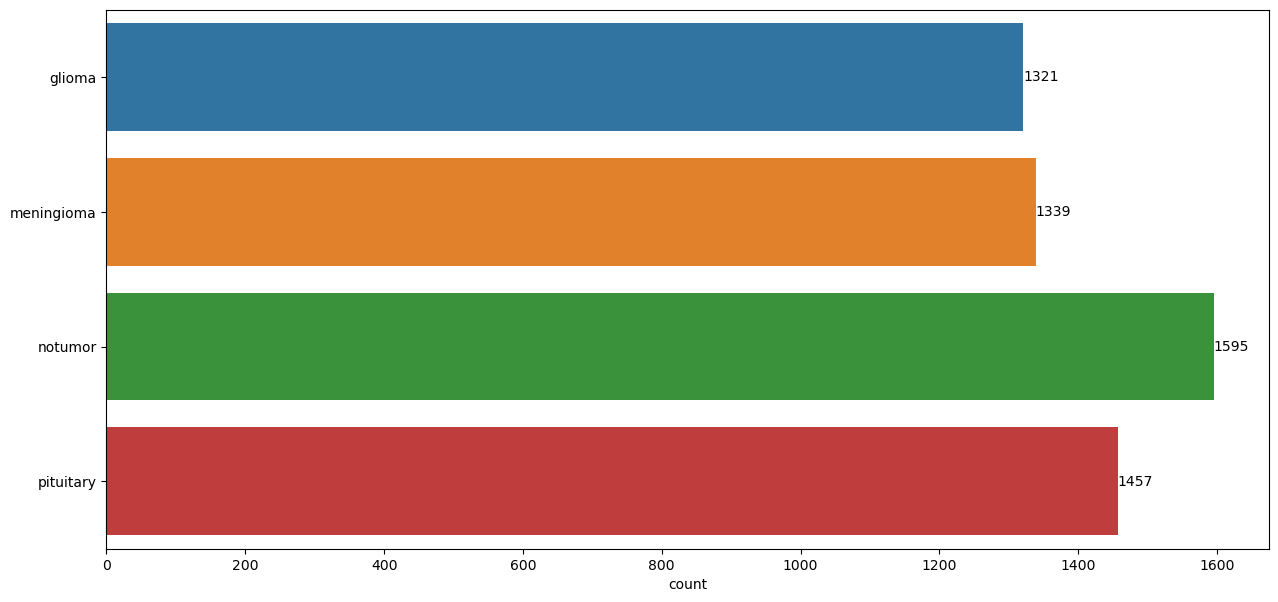

In [4]:
# -------------------------------------------------------
# 2. Load Dataset
# -------------------------------------------------------

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

dataset_path = "data/Training"   # change to Testing if needed
dataset = BrainTumorDataset(dataset_path, transform=transform)

print(f"Total images: {len(dataset)}")
print("Classes:", dataset.classes)
print("Class Lengths:", [dataset.labels.count(i) for i in range(len(dataset.classes))])
fig = plt.figure(figsize=(15, 7))
ax = sns.countplot(y=dataset.labels)
ax.set_yticklabels(dataset.classes)
ax.bar_label(ax.containers[0])
plt.show()



Total images: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class Lengths: [300, 306, 405, 300]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


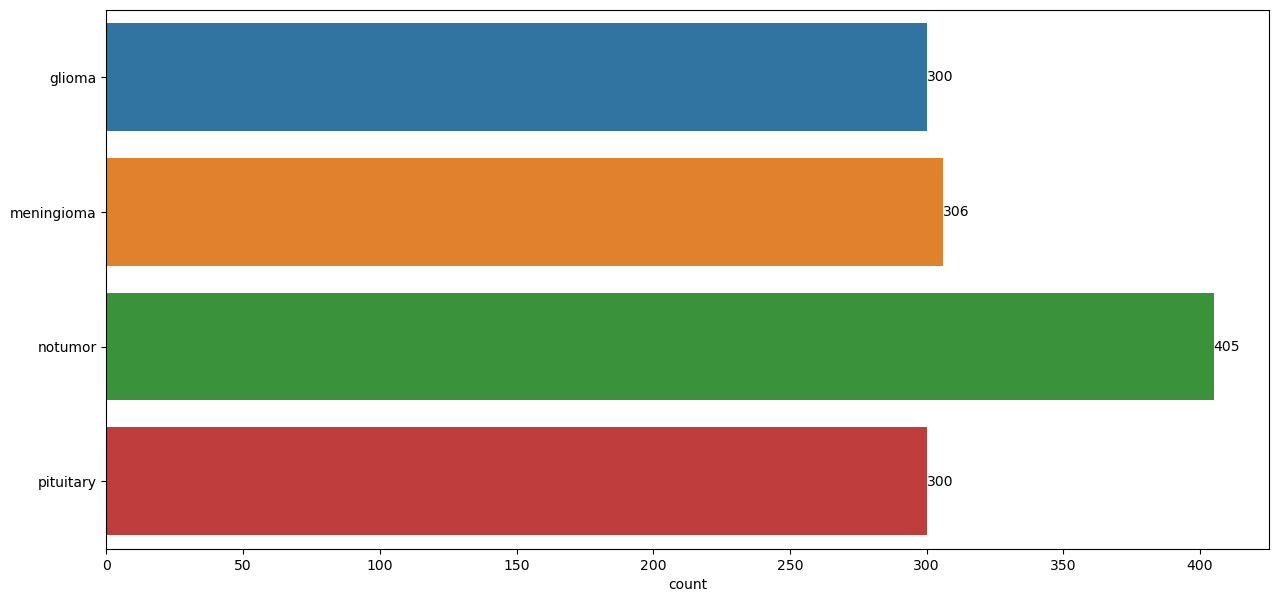

In [5]:
test_dataset_path = "data/Testing"
test_dataset = BrainTumorDataset(test_dataset_path, transform=transform)
print(f"Total images: {len(test_dataset)}")
print("Classes:", test_dataset.classes)
print("Class Lengths:", [test_dataset.labels.count(i) for i in range(len(test_dataset.classes))])
fig = plt.figure(figsize=(15, 7))
ax = sns.countplot(y=test_dataset.labels)
ax.set_yticklabels(test_dataset.classes)
ax.bar_label(ax.containers[0])
plt.show()


torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


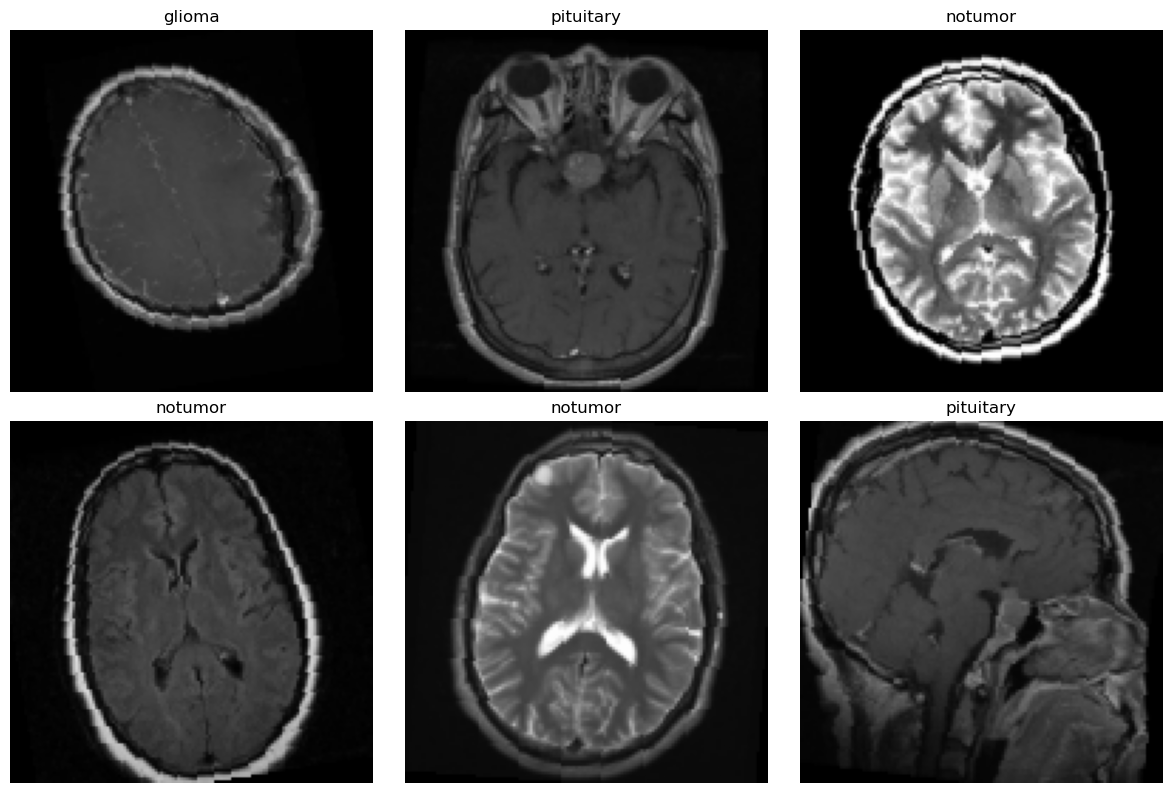

In [6]:
# -------------------------------------------------------
# 3. Display Random Images
# -------------------------------------------------------

def show_random_images(dataset, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        image, label = dataset[idx]

        # Convert tensor → numpy image
        print(image.shape)
        image_np = image.permute(1,2,0).numpy()

        plt.subplot(2, 3, i+1)
        plt.imshow(image_np)
        plt.title(dataset.classes[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(dataset, num_images=6)

In [7]:
trainloader = DataLoader(dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch
class CNN_network(nn.Module):
    def __init__(self, activation="relu", num_classes=4):
        super().__init__()

        activations = {
            "relu": F.relu,
            "tanh": torch.tanh,
            "sigmoid": torch.sigmoid,
            "leaky_relu": F.leaky_relu,
        }
        self.activation = activation
        self.activation_fn = activations[activation]

        # 1. Increase filters slightly to capture more detail
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Deeper filters

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        # 2. CALCULATE FLATTEN SIZE
        # Assuming input image is 128x128:
        # After Pool 1: 64x64
        # After Pool 2: 32x32
        # After Pool 3: 16x16
        # Final shape: 128 channels * 16 * 16
        self.flatten_size = 128 * 16 * 16 

        # 3. Standard Dense Layers (No Global Pool bottleneck)
        self.fc1 = nn.Linear(self.flatten_size, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.latest_feature_map = None

    def forward(self, x):
        # Apply Pool at every step to reduce size gradually
        x = self.activation_fn(self.conv1(x))
        x = self.pool(x) # 128 -> 64
        self.latest_feature_map = x.detach().cpu()

        x = self.activation_fn(self.conv2(x))
        x = self.pool(x) # 64 -> 32

        x = self.activation_fn(self.conv3(x))
        x = self.pool(x) # 32 -> 16
        
        # Flatten preserves all spatial info
        x = torch.flatten(x, 1) 

        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        
        x = self.activation_fn(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

In [10]:
from torchsummary import summary
summary(CNN_network(activation="relu", num_classes=4), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 512]      16,777,728
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
          Dropout-10                  [-1, 128]               0
           Linear-11                    [-1, 4]             516
Total params: 16,937,156
Trainable params: 16,937,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Fo

train for longer epochs 20
F1 Scores, of the model and metrics not just graphs, 
accurry of the test dataset vs validation datest. 
graph training loss vs validation loss
fix the graph of confusion matrix. 

I will make sigmoid vs leaky relu, 
then final graph with everything.

Running on device: mps
Class names: ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

=== Starting Training: relu ===
Epoch 1/20 | Train Loss: 0.7577 Acc: 0.6870 | Val Loss: 0.6676 Acc: 0.7414
Epoch 2/20 | Train Loss: 0.4743 Acc: 0.8160 | Val Loss: 0.4294 Acc: 0.8307
Epoch 3/20 | Train Loss: 0.3614 Acc: 0.8627 | Val Loss: 0.4031 Acc: 0.8230
Epoch 4/20 | Train Loss: 0.2982 Acc: 0.8825 | Val Loss: 0.2800 Acc: 0.8856
Epoch 5/20 | Train Loss: 0.2384 Acc: 0.9112 | Val Loss: 0.2995 Acc: 0.8764
Epoch 6/20 | Train Loss: 0.2248 Acc: 0.9167 | Val Loss: 0.2397 Acc: 0.9069
Epoch 7/20 | Train Loss: 0.1582 Acc: 0.9426 | Val Loss: 0.2036 Acc: 0.9321
Epoch 8/20 | Train Loss: 0.1428 Acc: 0.9473 | Val Loss: 0.2022 Acc: 0.9352
Epoch 9/20 | Train Loss: 0.1183 Acc: 0.9571 | Val Loss: 0.1711 Acc: 0.9390
Epoch 10/20 | Train Loss: 0.1036 Acc: 0.9627 | Val Loss: 0.1671 Acc: 0.9489
Epoch 11/20 | Train Loss: 0.0964 Acc: 0.9671 | Val Loss: 0.2056 Acc: 0.9314
Epoch 12/20 | Train Loss: 0.0862 Acc: 0.9702 | Val Los

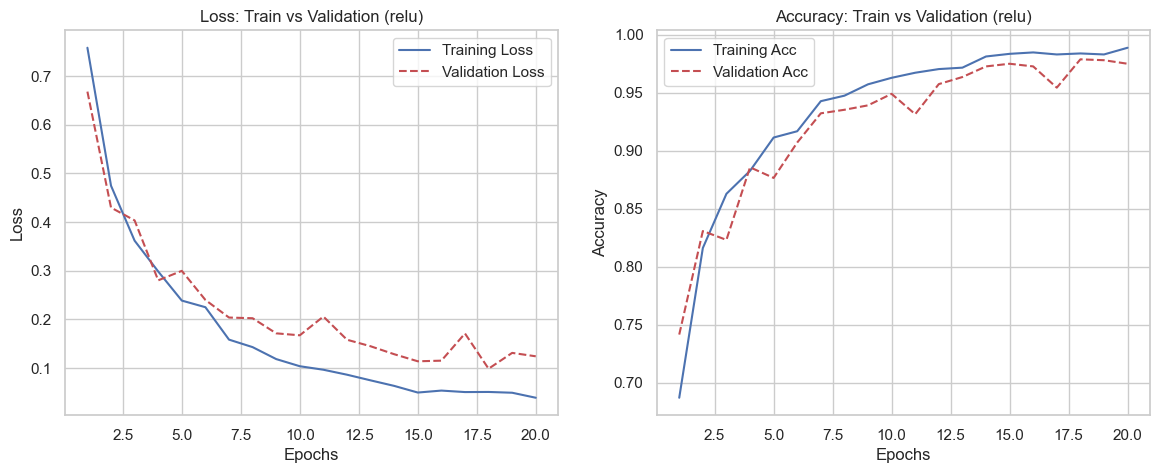

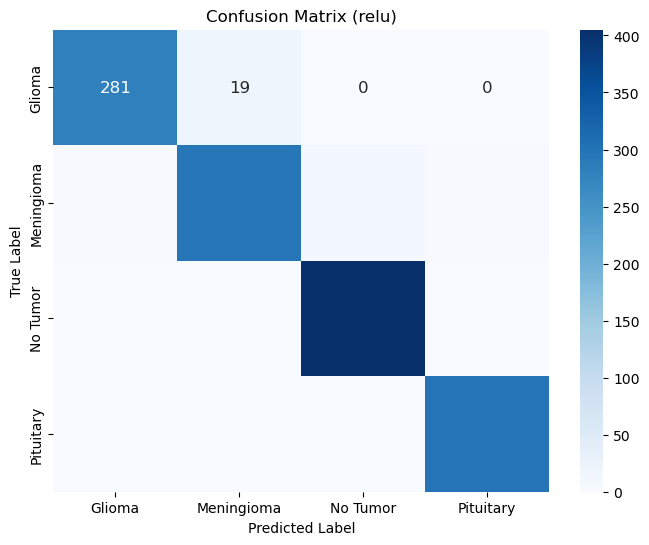

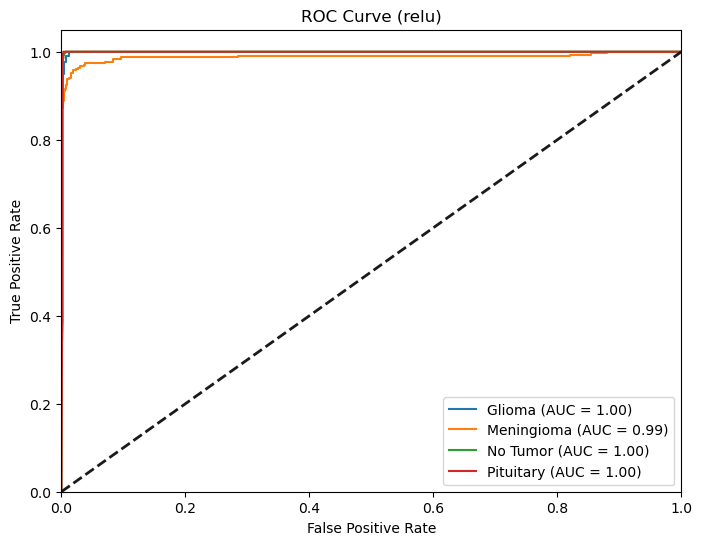

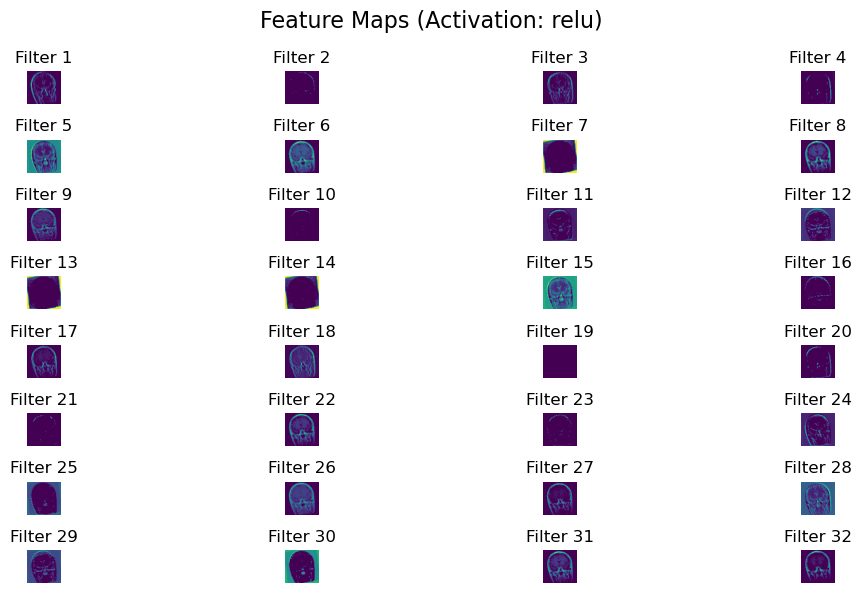


=== Starting Training: tanh ===
Epoch 1/20 | Train Loss: 0.7102 Acc: 0.7059 | Val Loss: 0.6187 Acc: 0.7368
Epoch 2/20 | Train Loss: 0.5094 Acc: 0.8002 | Val Loss: 0.5794 Acc: 0.7902
Epoch 3/20 | Train Loss: 0.5110 Acc: 0.7974 | Val Loss: 0.5581 Acc: 0.7750
Epoch 4/20 | Train Loss: 0.5356 Acc: 0.7892 | Val Loss: 0.5541 Acc: 0.7674
Epoch 5/20 | Train Loss: 0.5043 Acc: 0.8086 | Val Loss: 0.5927 Acc: 0.7521
Epoch 6/20 | Train Loss: 0.5087 Acc: 0.8020 | Val Loss: 0.5304 Acc: 0.8024
Epoch 7/20 | Train Loss: 0.5305 Acc: 0.7892 | Val Loss: 0.6844 Acc: 0.7338
Epoch 8/20 | Train Loss: 0.5108 Acc: 0.7946 | Val Loss: 0.5258 Acc: 0.7864
Epoch 9/20 | Train Loss: 0.4733 Acc: 0.8118 | Val Loss: 0.5913 Acc: 0.7666
Epoch 10/20 | Train Loss: 0.5188 Acc: 0.7980 | Val Loss: 0.6215 Acc: 0.7613
Epoch 11/20 | Train Loss: 0.5134 Acc: 0.7994 | Val Loss: 0.6107 Acc: 0.7567
Epoch 12/20 | Train Loss: 0.5015 Acc: 0.8065 | Val Loss: 0.5304 Acc: 0.7811
Epoch 13/20 | Train Loss: 0.5300 Acc: 0.7920 | Val Loss: 0.5549 

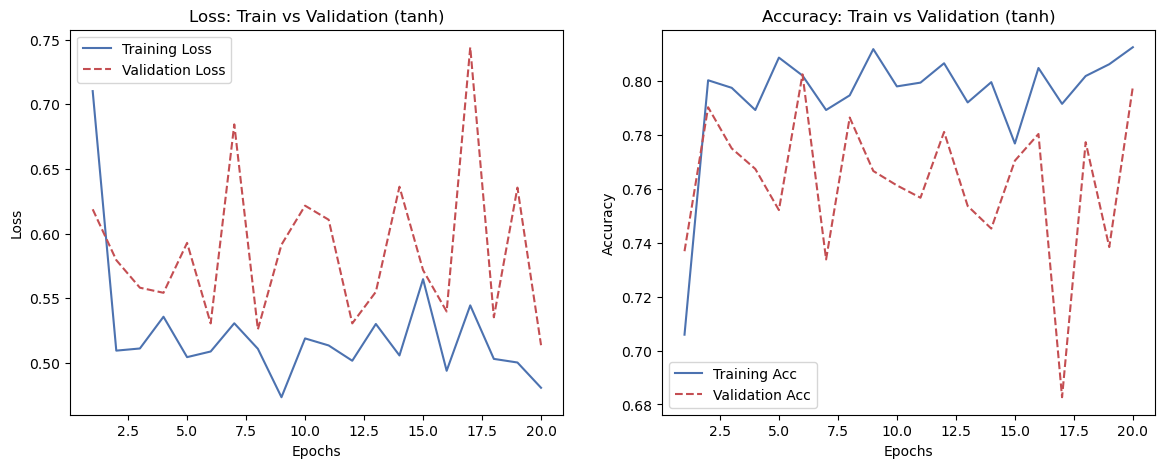

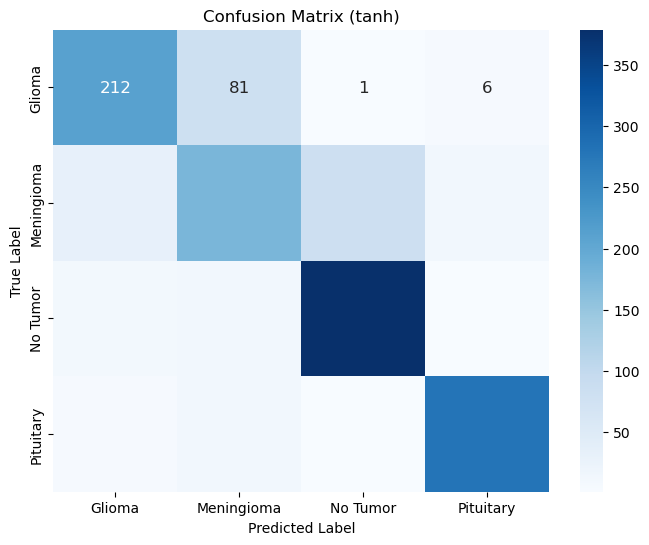

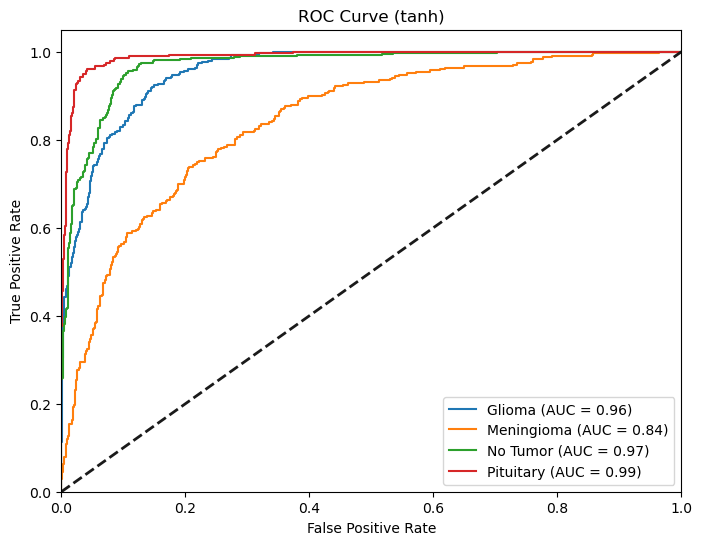

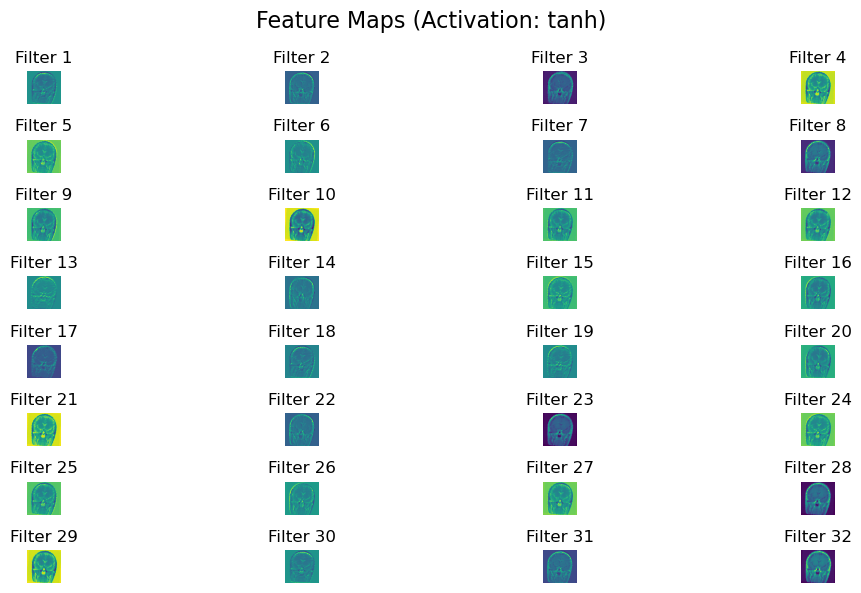

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

# Set style for plots
sns.set(style="whitegrid")

# -------------------- 1. CONFIGURATION --------------------
# Define your class names here for the plots
CLASS_NAMES = ["Glioma", "Meningioma", "No Tumor", "Pituitary"] 
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
EPOCHS = 20  # Increased to 20 as requested

# -------------------- 2. VISUALIZATION & METRICS TOOLS --------------------

def plot_feature_maps(model):
    """Plots the feature maps of the first layer from the last forward pass."""
    if model.latest_feature_map is None:
        print("No feature maps found. Run a forward pass first.")
        return

    fmap = model.latest_feature_map[0] # Take first image in batch
    num_maps = fmap.shape[0]
    
    cols = 4
    rows = int(np.ceil(num_maps / cols))

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Feature Maps (Activation: {model.activation})", fontsize=16)
    
    for i in range(num_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(fmap[i].detach().cpu().numpy(), cmap='viridis')
        plt.axis('off')
        plt.title(f"Filter {i+1}")
    plt.tight_layout()
    plt.show()

def print_binary_metrics_per_class(cm, classes):
    """
    Prints TP, TN, FP, FN for each class (One-vs-Rest approach).
    This answers the request for '2x2' metrics in a multi-class setting.
    """
    print("\n--- Per-Class 2x2 Matrix Breakdown ---")
    for i, class_label in enumerate(classes):
        # True Positive: Diagonal
        TP = cm[i, i]
        # False Positive: Sum of column i minus TP
        FP = cm[:, i].sum() - TP
        # False Negative: Sum of row i minus TP
        FN = cm[i, :].sum() - TP
        # True Negative: Total sum minus (TP + FP + FN)
        TN = cm.sum() - (TP + FP + FN)
        
        print(f"Class: {class_label}")
        print(f"  TP: {TP:<5} | FP: {FP:<5}")
        print(f"  FN: {FN:<5} | TN: {TN:<5}")
        print("-" * 30)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(cm, activation_name, class_names):
    # 1. Reset plot style to ensure text is visible (fixes Dark Mode issues)
    plt.style.use('default') 
    
    plt.figure(figsize=(8, 6))

    cm = confusion_matrix
    
    # 2. Plot Heatmap
    # annot=True: Show numbers inside cells
    # fmt='d': Format as integers
    # cbar=True: Show the color scale bar on the side
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}) # Increase font size
    
    plt.title(f"Confusion Matrix ({activation_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def plot_roc_curve(true_labels, probs, class_names, activation_name):
    """Plots ROC curves with specific class names in the legend."""
    n_classes = len(class_names)
    y_test_bin = label_binarize(true_labels, classes=range(n_classes))
    
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        if np.sum(y_test_bin[:, i]) > 0: 
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({activation_name})")
    plt.legend(loc="lower right")
    plt.show()

def plot_training_history(history, activation_name):
    """Plots Train vs Validation Loss and Accuracy side-by-side."""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r--', label='Validation Loss')
    plt.title(f"Loss: Train vs Validation ({activation_name})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r--', label='Validation Acc')
    plt.title(f"Accuracy: Train vs Validation ({activation_name})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

# -------------------- 3. TRAINING ENGINE --------------------
def train_model(model, trainloader, testloader, device, epochs=20, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # History dictionary
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }
    
    model.to(device)
    print(f"\n=== Starting Training: {model.activation} ===")

    for epoch in range(epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = correct_train / total_train
        
        # --- VALIDATION PHASE ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Lists for final evaluation
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item()
                
                # Softmax for probabilities
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                if epoch == epochs - 1: # Save predictions only for last epoch
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())

        epoch_val_loss = running_val_loss / len(testloader)
        epoch_val_acc = correct_val / total_val

        # Save history
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_acc"].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    return {
        "history": history,
        "preds": np.array(all_preds),
        "labels": np.array(all_labels),
        "probs": np.array(all_probs)
    }

# -------------------- 4. COMPARISON DRIVER --------------------
def compare_activations(activations, trainloader, testloader, device, epochs=20):
    for act in activations:
        # Initialize model (Assuming CNN_network class exists in your scope)
        model = CNN_network(activation=act, num_classes=len(CLASS_NAMES))
        
        # Train
        data = train_model(model, trainloader, testloader, device, epochs=epochs)
        
        preds = data["preds"]
        labels = data["labels"]
        history = data["history"]
        
        # --- 1. METRICS & REPORTS ---
        cm = confusion_matrix(labels, preds)
        
        print(f"\n\n>>> FINAL METRICS REPORT: {act.upper()} <<<")
        print("-" * 60)
        
        # Full Text Report (F1, Precision, Recall)
        print("Classification Report:")
        print(classification_report(labels, preds, target_names=CLASS_NAMES))
        
        # The '2x2' breakdown requested
        print_binary_metrics_per_class(cm, CLASS_NAMES)
        
        # --- 2. GRAPHS ---
        # A. Training vs Validation Curves (Loss & Accuracy)
        plot_training_history(history, act)
        
        # B. Confusion Matrix
        plot_confusion_matrix(cm, act, CLASS_NAMES)
        
        # C. ROC Curve
        plot_roc_curve(labels, data["probs"], CLASS_NAMES, act)
        
        # D. Feature Maps
        plot_feature_maps(model)

# -------------------- MAIN EXECUTION --------------------
if __name__ == "__main__":
    # Ensure trainloader and testloader are defined before running this!
    # Example usage:
    ACTIVATIONS_TO_COMPARE = ["relu", "tanh"] # Add others as needed
    
    print(f"Running on device: {DEVICE}")
    print(f"Class names: {CLASS_NAMES}")
    
    # Run the comparison
    compare_activations(ACTIVATIONS_TO_COMPARE, trainloader, testloader, DEVICE, EPOCHS)